In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(20, 20, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [4]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size * 3, hidden_size * 2)

        self.attention = eca_layer(64)
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        attention_input = torch.cat((h_reshaped, encoder_states), dim=2)
        attention_input = attention_input.transpose(0,1)
        context_vector = self.attention(attention_input)
        context_vector = self.linear(context_vector)
        context_vector = context_vector.transpose(0,1)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [7]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[0.0291],
        [0.0215],
        [0.0194],
        [0.0147],
        [0.0252]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [10]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [11]:
df_for_training=df[feature_names].astype(float)

In [12]:
df_for_training.shape

(11524, 22)

In [13]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [14]:
trainX=[]
trainY=[]

In [15]:
n_future=1
n_past=20

In [16]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [17]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [18]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [19]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [20]:
data,label=random_shuffle(trainX,trainY)

In [21]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [23]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.06027453392744064
Epoch: 1 Loss: 0.22922834753990173
Epoch: 2 Loss: 0.07701625674962997
Epoch: 3 Loss: 0.02808118239045143
Epoch: 4 Loss: 0.2444058656692505
Epoch: 5 Loss: 0.07060635089874268
Epoch: 6 Loss: 0.11015041917562485
Epoch: 7 Loss: 0.08381030708551407
Epoch: 8 Loss: 0.018620973452925682
Epoch: 9 Loss: 0.04941302537918091
Epoch: 10 Loss: 0.0799492597579956
Epoch: 11 Loss: 0.07002023607492447
Epoch: 12 Loss: 0.03562163561582565
Epoch: 13 Loss: 0.06886548548936844
Epoch: 14 Loss: 0.02770804613828659
Epoch: 15 Loss: 0.05426475778222084
Epoch: 16 Loss: 0.05199206992983818
Epoch: 17 Loss: 0.057233311235904694
Epoch: 18 Loss: 0.04520799219608307
Epoch: 19 Loss: 0.10182878375053406
Epoch: 20 Loss: 0.03597867488861084
Epoch: 21 Loss: 0.030510634183883667
Epoch: 22 Loss: 0.05577472597360611
Epoch: 23 Loss: 0.06159384548664093
Epoch: 24 Loss: 0.014559146948158741
Epoch: 25 Loss: 0.03759292513132095
Epoch: 26 Loss: 0.02906644530594349
Epoch: 27 Loss: 0.01806795969605446


Epoch: 221 Loss: 0.01624884456396103
Epoch: 222 Loss: 0.018947971984744072
Epoch: 223 Loss: 0.013951312750577927
Epoch: 224 Loss: 0.01586046814918518
Epoch: 225 Loss: 0.015537718310952187
Epoch: 226 Loss: 0.009561557322740555
Epoch: 227 Loss: 0.013770246878266335
Epoch: 228 Loss: 0.005576468072831631
Epoch: 229 Loss: 0.0032659717835485935
Epoch: 230 Loss: 0.0380314476788044
Epoch: 231 Loss: 0.0036956090480089188
Epoch: 232 Loss: 0.007989202626049519
Epoch: 233 Loss: 0.01013009250164032
Epoch: 234 Loss: 0.015211164951324463
Epoch: 235 Loss: 0.018930424004793167
Epoch: 236 Loss: 0.009758302010595798
Epoch: 237 Loss: 0.0023248358629643917
Epoch: 238 Loss: 0.003307294100522995
Epoch: 239 Loss: 0.023967625573277473
Epoch: 240 Loss: 0.023345237597823143
Epoch: 241 Loss: 0.012563052587211132
Epoch: 242 Loss: 0.002974251750856638
Epoch: 243 Loss: 0.018951652571558952
Epoch: 244 Loss: 0.005401067901402712
Epoch: 245 Loss: 0.008118768222630024
Epoch: 246 Loss: 0.02991608902812004
Epoch: 247 Loss

Epoch: 438 Loss: 0.005069279577583075
Epoch: 439 Loss: 0.00767548568546772
Epoch: 440 Loss: 0.020390210673213005
Epoch: 441 Loss: 0.007636381313204765
Epoch: 442 Loss: 0.0033974121324718
Epoch: 443 Loss: 0.022009780630469322
Epoch: 444 Loss: 0.009832778014242649
Epoch: 445 Loss: 0.009430021978914738
Epoch: 446 Loss: 0.005439537577331066
Epoch: 447 Loss: 0.02502317726612091
Epoch: 448 Loss: 0.005898907780647278
Epoch: 449 Loss: 0.006106923799961805
Epoch: 450 Loss: 0.02464103512465954
Epoch: 451 Loss: 0.004894094541668892
Epoch: 452 Loss: 0.01954430714249611
Epoch: 453 Loss: 0.014310757629573345
Epoch: 454 Loss: 0.014519024640321732
Epoch: 455 Loss: 0.011684306897222996
Epoch: 456 Loss: 0.007743140682578087
Epoch: 457 Loss: 0.006421227008104324
Epoch: 458 Loss: 0.010914526879787445
Epoch: 459 Loss: 0.006900391541421413
Epoch: 460 Loss: 0.003496144898235798
Epoch: 461 Loss: 0.00824490562081337
Epoch: 462 Loss: 0.012455441989004612
Epoch: 463 Loss: 0.015405122190713882
Epoch: 464 Loss: 0.

Epoch: 655 Loss: 0.008685784414410591
Epoch: 656 Loss: 0.004272271879017353
Epoch: 657 Loss: 0.004983397200703621
Epoch: 658 Loss: 0.007113204337656498
Epoch: 659 Loss: 0.005746167153120041
Epoch: 660 Loss: 0.002595853991806507
Epoch: 661 Loss: 0.01132612582296133
Epoch: 662 Loss: 0.015128952451050282
Epoch: 663 Loss: 0.007827164605259895
Epoch: 664 Loss: 0.023754408583045006
Epoch: 665 Loss: 0.011113053187727928
Epoch: 666 Loss: 0.0035397587344050407
Epoch: 667 Loss: 0.015266453847289085
Epoch: 668 Loss: 0.011908215470612049
Epoch: 669 Loss: 0.013138278387486935
Epoch: 670 Loss: 0.010665347799658775
Epoch: 671 Loss: 0.004312125965952873
Epoch: 672 Loss: 0.01101660542190075
Epoch: 673 Loss: 0.01699758507311344
Epoch: 674 Loss: 0.013389641419053078
Epoch: 675 Loss: 0.0034997458569705486
Epoch: 676 Loss: 0.008508522994816303
Epoch: 677 Loss: 0.01016005128622055
Epoch: 678 Loss: 0.0024667754769325256
Epoch: 679 Loss: 0.0038751340471208096
Epoch: 680 Loss: 0.01644989475607872
Epoch: 681 Lo

Epoch: 871 Loss: 0.003190130926668644
Epoch: 872 Loss: 0.005712753161787987
Epoch: 873 Loss: 0.01001010462641716
Epoch: 874 Loss: 0.007489336654543877
Epoch: 875 Loss: 0.0036276085302233696
Epoch: 876 Loss: 0.004399867728352547
Epoch: 877 Loss: 0.007673883810639381
Epoch: 878 Loss: 0.008228853344917297
Epoch: 879 Loss: 0.02299729362130165
Epoch: 880 Loss: 0.002685999497771263
Epoch: 881 Loss: 0.009484299458563328
Epoch: 882 Loss: 0.013650765642523766
Epoch: 883 Loss: 0.0019370175432413816
Epoch: 884 Loss: 0.009779300540685654
Epoch: 885 Loss: 0.008546159602701664
Epoch: 886 Loss: 0.009693806059658527
Epoch: 887 Loss: 0.0044206781312823296
Epoch: 888 Loss: 0.013075590133666992
Epoch: 889 Loss: 0.018382277339696884
Epoch: 890 Loss: 0.002998942509293556
Epoch: 891 Loss: 0.006098540034145117
Epoch: 892 Loss: 0.002950676716864109
Epoch: 893 Loss: 0.0074143242090940475
Epoch: 894 Loss: 0.014727426692843437
Epoch: 895 Loss: 0.01203944068402052
Epoch: 896 Loss: 0.01042456179857254
Epoch: 897 L

In [24]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [26]:
predictions = np.array(predictions)

In [27]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [28]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

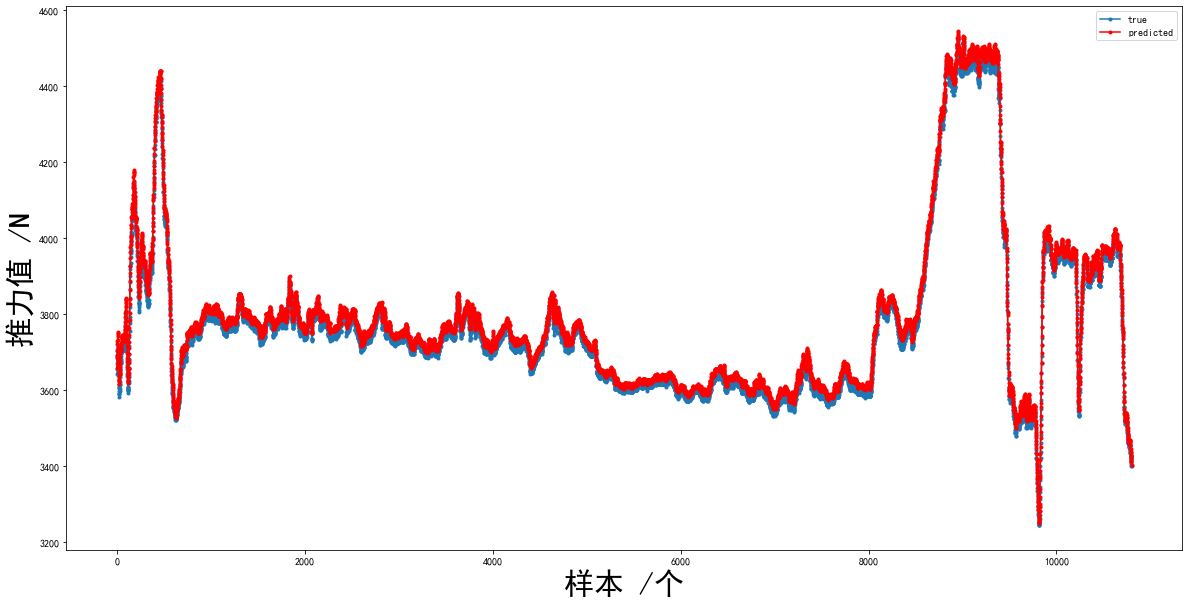

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();